In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [3]:
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [5]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15, 5))
    plt.title("Moving Average\nWindow Size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_intervals:
        MAE = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (MAE + scale * deviation)
        upper_bond = rolling_mean + (MAE + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="lower left")
    plt.grid(True)
        

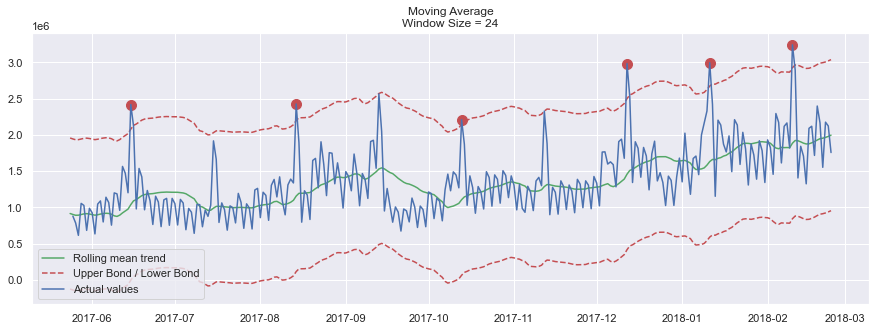

In [6]:
plotMovingAverage(currency, 24, plot_intervals=1, plot_anomalies=1)

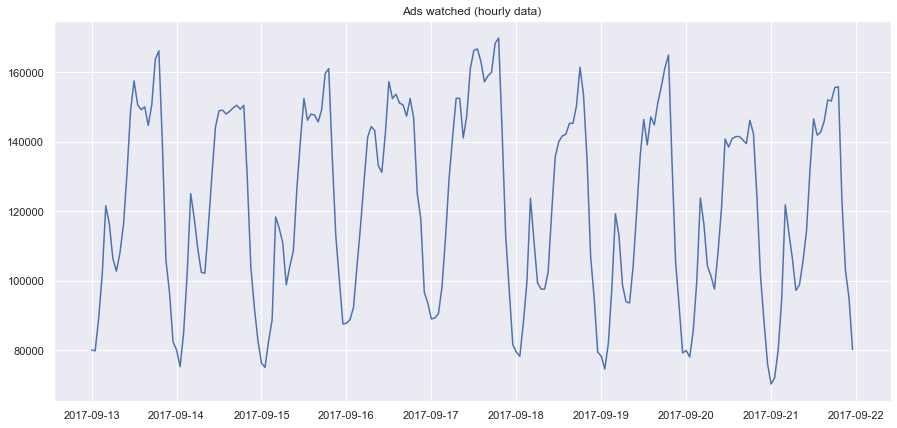

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

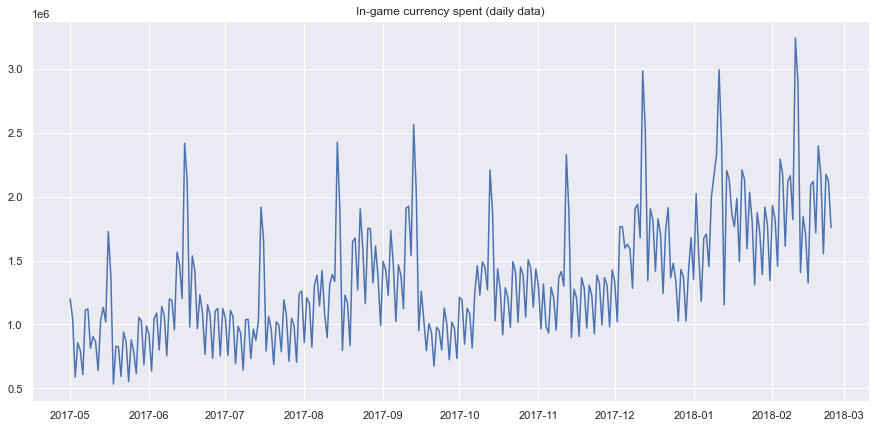

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [9]:
def expotential_smoothing(series, alpha):
    result = [series[0]] # 因为第一个值不存在指数平滑值
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [10]:
def plotExpotentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(expotential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Expotential Smoothing")
        plt.grid(True)

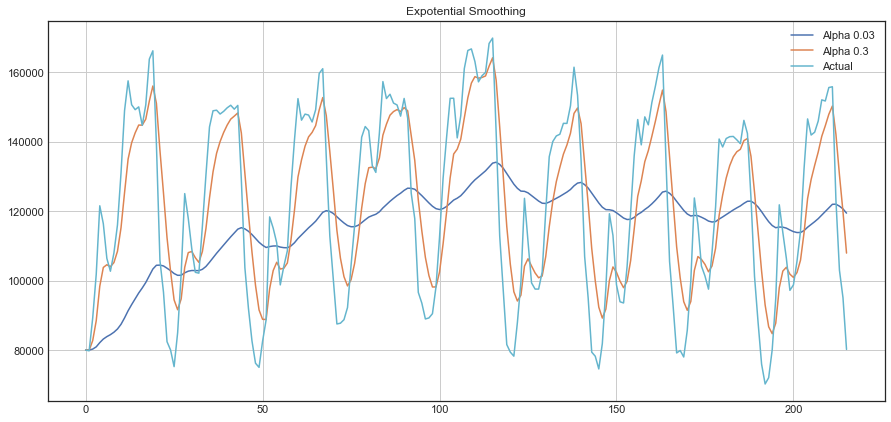

In [11]:
plotExpotentialSmoothing(ads.Ads, [0.03, 0.3])

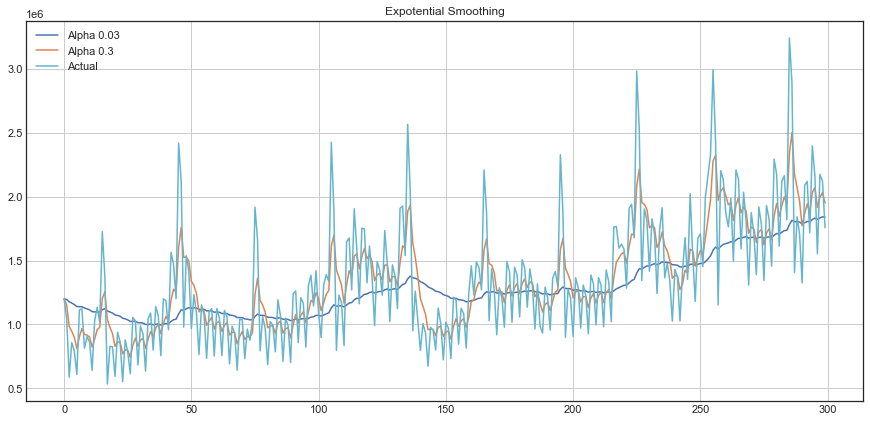

In [12]:
plotExpotentialSmoothing(currency.GEMS_GEMS_SPENT, [0.03, 0.3])

In [1]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # 计算季节平均
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/self.slen)
        # 计算季节值
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals
    
    def triple_expotential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(
                    self.result[0] +
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                self.LowerBond.append(
                    self.result[0] -
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                continue
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i % self.slen])
                
                # 预测会每步的不确定性
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                
                # Deviation 按照 Brutlag 算法计算
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                              + (1 - self.gamma) * self.PredictedDeviation[-1])
            
            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )
            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])